In [14]:
import os
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy
from classifiers import *
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import CubicSpline
import math

In [2]:
# Dataset loader

def moon_load(num_samples=700, noise=0.05):
    data = make_moons(noise=noise, random_state=0,n_samples = num_samples)

    # preprocess dataset, split into training and test part
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
    
    return(X_train, y_train, X_test, y_test)

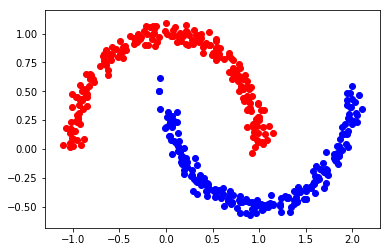

In [3]:
# Load halfmoon dataset
noise = 0.05
num_samples = 700
X_train, y_train, X_test, y_test = moon_load(num_samples,noise)

num_samples_print = min(num_samples,500)
i = 0
for x,y in zip(X_train,y_train):
    if(i > num_samples_print):
        break
    if(y == 0):
        color = 'red'
    else:
        color = 'blue'
    plt.scatter(x[0],x[1],c=color)
    
    i+=1
    
plt.show()

In [4]:
# Create points for optimal decision boundary
num_pts = 100
radius = 1.0

thetas = np.linspace(0.0,np.pi,num_pts)
red_x = [radius*np.cos(theta) for theta in thetas]
red_y = [radius*np.sin(theta) for theta in thetas]
red_pts = []

thetas = np.linspace(-np.pi,0,num_pts)
blue_x = [radius*np.cos(theta)+1.0 for theta in thetas]
blue_y = [radius*np.sin(theta)+0.5 for theta in thetas]
blue_pts = []

for x,y in zip(red_x,red_y):
    red_pts.append(np.asarray([x,y]))
for x,y in zip(blue_x,blue_y):
    blue_pts.append(np.asarray([x,y]))

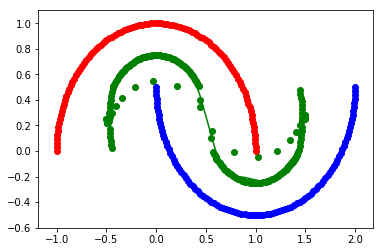

In [5]:
def special_sort(pts):
    # Find sorting indices
    array_to_sort = [pt[0] for pt in pts]
    indices = np.argsort(array_to_sort)
    
    # Sort points
    sorted_pts = [boundary_pts[i] for i in indices]
    
    # Delete duplicated points
    sorted_x = [array_to_sort[i] for i in indices]
    diff = np.diff(sorted_x)
    zero_indices = [index for index,value in enumerate(diff) if value <= pow(10,-9)]
    sorted_pts = [sorted_pts[index] 
                  for index in np.arange(0,len(diff))
                  if index not in zero_indices ]
    return sorted_pts
    

def nn_in_set(element, search_set):
    nn = search_set[0]
    min_dist = np.linalg.norm(element-search_set[0])
    for point in search_set:
        distance = np.linalg.norm(element-point)
        if(distance < min_dist):
            nn = point
    return nn


# Find optimal decision boundary (approximately)
# red_pts = [x for x,y in zip(X_train,y_train) if y == 0]
# blue_pts = [x for x,y in zip(X_train,y_train) if y == 1]

boundary_pts = []

# for subset,opp_subset in zip([red_pts,blue_pts],[blue_pts,red_pts]):
    
subset = red_pts
opp_subset = blue_pts
for x in subset:
    nn = nn_in_set(x,opp_subset)
    midpoint = np.divide(x+nn,2)
    boundary_pts.append(midpoint)
subset = blue_pts
opp_subset = red_pts
for x in subset:
    nn = nn_in_set(x,opp_subset)
    midpoint = np.divide(x+nn,2)
    boundary_pts.append(midpoint)
        
# Sort data (ascending x values)
boundary_pts = special_sort(boundary_pts)

# Slice array
pt_x = [pt[0] for pt in boundary_pts ]
pt_y = [pt[1] for pt in boundary_pts]

# Find spline approximation
# spline = CubicSpline(pt_x, pt_y)
# new_x = pt_x
# ynew = spline(new_x)
# tck = scipy.interpolate.splrep(pt_x, pt_y)
# ynew = scipy.interpolate.splev(pt_x, tck)

s = scipy.interpolate.UnivariateSpline(pt_x, pt_y, s=1,k=3)
ynew = s(pt_x)

plt.plot(pt_x,ynew,c = 'green')

i = 0
for x,y in zip(pt_x,pt_y):
    if(i > num_samples_print):
        break
    plt.scatter(x,y,c='green')
    i+=1
    
i=0
for red_pt,blue_pt in zip(red_pts,blue_pts):
    if(i > num_samples_print):
        break
    plt.scatter(red_pt[0],red_pt[1],c='red')
    plt.scatter(blue_pt[0],blue_pt[1],c='blue')
    i+=1
plt.show()

In [6]:
#-----------------------------------------------------------------
# Set up Classifier + training parameters
#-----------------------------------------

train_classifier = True
reuse = not train_classifier

learning_rate = 0.001
num_epochs = 500
batch_size = 100
x_size = 2
y_size = 2
x = tf.placeholder(tf.float32, shape=[None, x_size])
y = tf.placeholder(tf.int32, shape=[None, y_size])
classifier_model_fn = lambda x,reuse_flag: dnn_model_fn_deeper(x,reuse_flag)
logits, classifier_params = classifier_model_fn(x,reuse)

# Load Training Data + Define Model
# load_func = utils.MNIST_load
load_func = moon_load
classifier_saver = tf.train.Saver(var_list=classifier_params, max_to_keep=1)
classifier_model_directory = "./model_Classifier/2d/"


# Define Training Operation
train_op = get_train_op(logits, y, learning_rate)

# Initialization
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True






In [7]:
#-----------------------------------------------------------------
# Train Classifier
#-----------------------------------------

sess = tf.InteractiveSession()
sess.run(init)

if train_classifier:
    print ('Start Training Classifier')
    train_epoch, _, test_epoch = utils.load_dataset(batch_size, load_func)
    print('training model')
    train_model(sess, x, y, train_epoch, train_op, num_epochs, batch_size)
    print('saving model')
    save_model(sess,classifier_saver,classifier_model_directory)
else:
    print('Load Classifier')
    restore_model(sess,classifier_saver,classifier_model_directory)
    print('Loaded from:')
    print(classifier_model_directory)
    


Start Training Classifier
training model
saving model


In [8]:
#--------------------------------------------------
# Test Classifier
#----------------------------
accuracy_op = get_accuracy_op(logits, y)
batch_size = 100
train_epoch, _,test_epoch = utils.load_dataset(batch_size, load_func)
batch_gen = utils.batch_gen(test_epoch, True, y.shape[1], num_iter=1)
iteration = 0
normal_avr = 0
for points, labels in batch_gen:
    iteration += 1
    avr = sess.run(accuracy_op, feed_dict={x: points, y: labels})
    normal_avr += avr
print("Normal Accuracy:", normal_avr / iteration)

('Normal Accuracy:', 1.0)


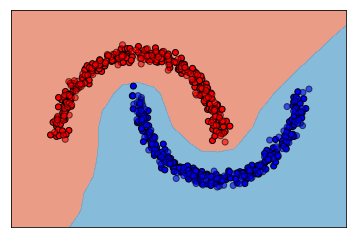

In [9]:
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

#-----------------------------------------------------------------
# Plot Classifier Decision Boundary
#-----------------------------------------

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

# Plot the decision boundary. For that, we will assign a prediction to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

h = .2  # step size in the mesh
x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
points = np.transpose([xx.ravel(),yy.ravel()])


Z = sess.run(logits, feed_dict={x: points})
Z = softmax(Z)
Z = np.asarray([pred[1] for pred in Z])

# Put the result into a color plot
ax = plt.axes()
shape = np.shape(xx)
Z = Z.reshape(shape)
num_contours = 1
ax.contourf(xx, yy, Z,num_contours, cmap=cm, alpha=.8)

# Plot training points 
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
           edgecolors='k')
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

plt.show()


Automatically created module for IPython interactive environment


/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


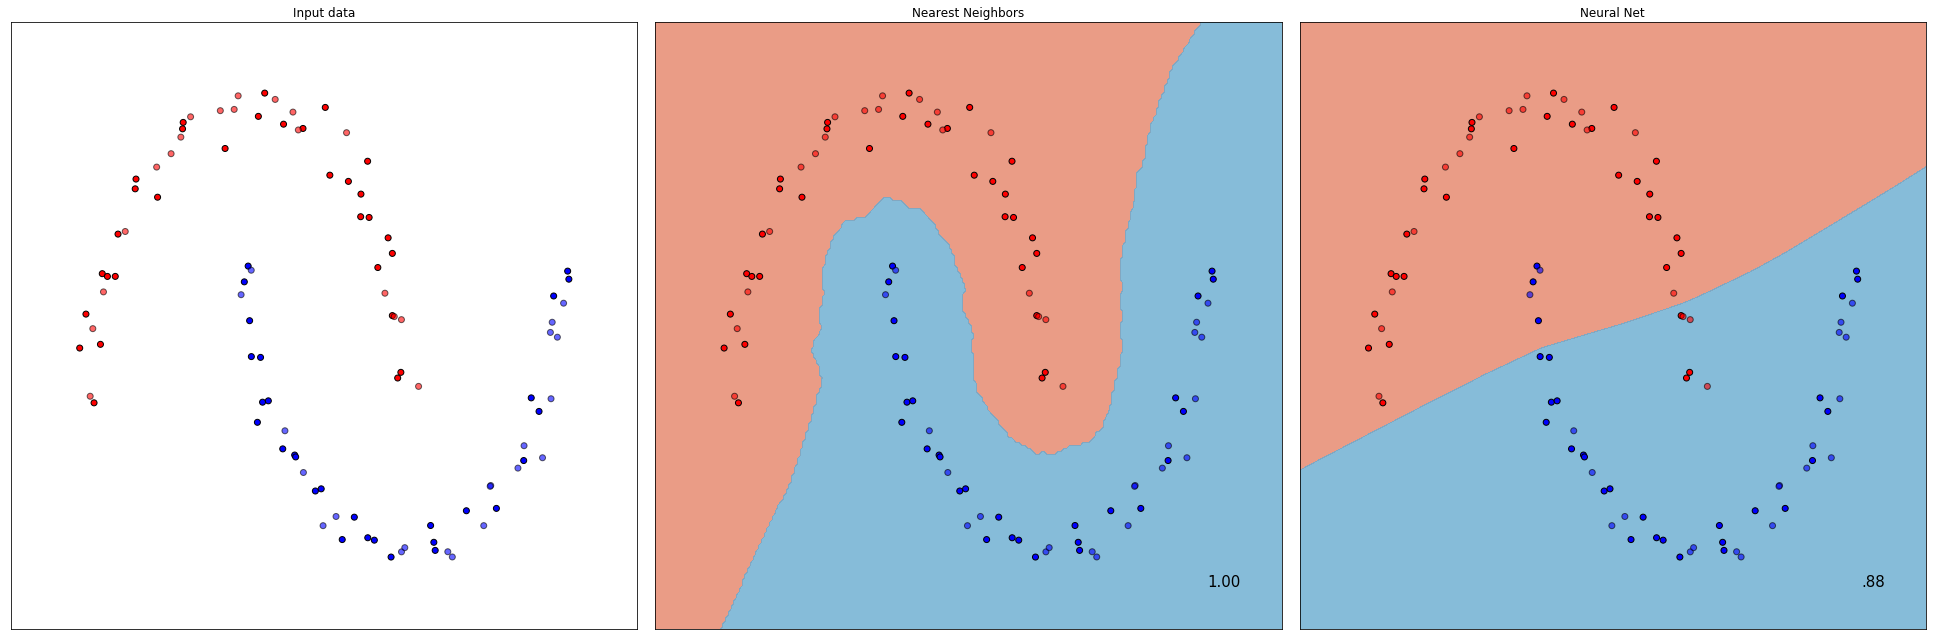

In [10]:
#-----------------------------------------------------------------
# Scikit Classifier
#-----------------------------------------

print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors","Neural Net"]

classifiers = [
    KNeighborsClassifier(3),
    MLPClassifier(alpha=1)]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.05, random_state=0)]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z,1, cmap=cm, alpha=.8)
        # ax.contour(xx, yy, Z,2,cmap=plt.cm.Paired)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

Automatically created module for IPython interactive environment


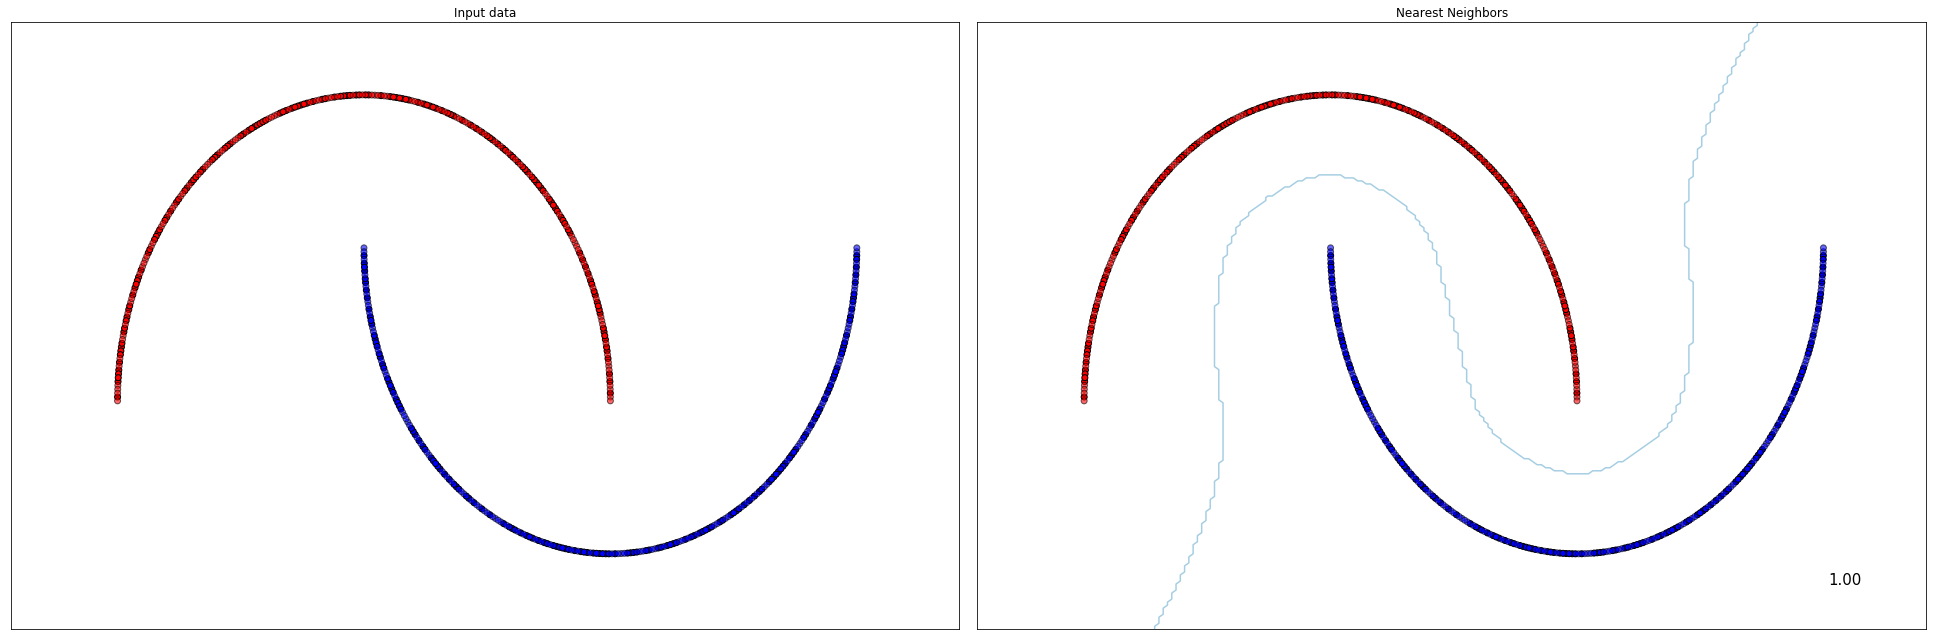

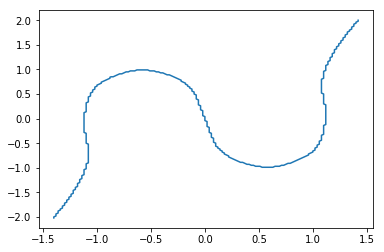

In [24]:
#-----------------------------------------------------------------
# Find optimal decision boundary (approximately)
#-----------------------------------------

#-----------------------------------------------------------------
# Scikit Classifier
#-----------------------------------------

print(__doc__)


h = .02  # step size in the mesh
num_samples = 500
n = num_samples
d = 2
# kneighbors = int(math.ceil(n*d*log(n)))
kneighbors = 1

names = ["Nearest Neighbors"]

classifiers = [
    KNeighborsClassifier(kneighbors),]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.0, random_state=0,n_samples=num_samples)]

figure = plt.figure(figsize=(27, 9))
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        #ax.contourf(xx, yy, Z,1, cmap=cm, alpha=.8)
        contour = ax.contour(xx, yy, Z,1,cmap=plt.cm.Paired)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

#-----------------------------------
# Get Ideal Decision Boundary
#-----------------------------

paths = contour.collections[0].get_paths()[0]
ideal_boundary = paths.vertices

In [ ]:
#--------------------------------------------------------
# Train several times (see distribution of boundaries)
#-----------------------------------